# AKARI-SEP master catalogue
## Preparation of Spitzer SIMES data

The Spitzer catalogues were produced by the datafusion team are available in `dmu0_SIMES`.
Lucia told that the magnitudes are aperture corrected.

In the catalouge, we keep:

- The internal identifier (this one is only in HeDaM data);
- The position;
- The fluxes in aperture 1 (4.8 arcsec);
- The total flux;
- The stellarity in each band

Paper descirbing data:
http://irsa.ipac.caltech.edu/data/SPITZER/SEP/documentation/baronchelli16.pdf


In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
0575207 (Wed Apr 28 17:44:47 2021 +0100)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag

/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "simes_ra"
DEC_COL = "simes_dec"

## I - Column selection

In [4]:
Table.read("../../dmu0/dmu0_SIMES/data/SEP_catalog8.0_mJy.fits").colnames

['ID',
 'RA',
 'DEC',
 'PHOTO_Z',
 'PHOTO_Z_ERR',
 'FLUX_I1',
 'FLUXERR_I1',
 'N_SIGMA',
 'FLUX_I2',
 'FLUXERR_I2',
 'RA_24',
 'DEC_24',
 'O_RA_24',
 'O_DEC_24',
 'FLUX_24',
 'FLUXERR_24',
 'FLUX_70',
 'FLUXERR_70',
 'RA_SPIRE',
 'DEC_SPIRE',
 'O_RA_SPIRE',
 'O_DEC_SPIRE',
 'FLUX_250',
 'FLUXERR_250',
 'FLUX_350',
 'FLUXERR_350',
 'FLUX_500',
 'FLUXERR_500',
 'RA_GALEX',
 'DEC_GALEX',
 'O_RA_GALEX',
 'O_DEC_GALEX',
 'FLUX_FUV_GALEX',
 'FLUXERR_FUV_GALEX',
 'FLUX_NUV_GALEX',
 'FLUXERR_NUV_GALEX',
 'RA_OPT',
 'DEC_OPT',
 'FLUX_U',
 'FLUXERR_U',
 'FLUX_B',
 'FLUXERR_B',
 'FLUX_V',
 'FLUXERR_V',
 'FLUX_I',
 'FLUXERR_I',
 'FLUX_R_WFI',
 'FLUXERR_R_WFI',
 'FLUX_G_VST',
 'FLUXERR_G_VST',
 'FLUX_I_VST',
 'FLUXERR_I_VST',
 'FLUX_Z_VST',
 'FLUXERR_Z_VST',
 'RA_VISTA',
 'DEC_VISTA',
 'O_RA_VISTA',
 'O_DEC_VISTA',
 'FLUX_J_VISTA',
 'FLUXERR_J_VISTA',
 'FLUX_H_VISTA',
 'FLUXERR_H_VISTA',
 'FLUX_KS_VISTA',
 'FLUXERR_KS_VISTA',
 'RA_W',
 'DEC_W',
 'O_RA_W',
 'O_DEC_W',
 'FLUX_W1',
 'FLUXERR_W1',
 'FL

In [5]:
imported_columns = OrderedDict({
        'ID': "simes_id",
        'RA': "simes_ra",
        'DEC': "simes_dec",
        'FLUX_I1': "f_irac_i1",
        'FLUXERR_I1': "ferr_irac_i1",
        'AP1_FLUX_I1': "f_ap_irac_i1",
        'AP1_FLUXERR_I1': "ferr_ap_irac_i1",
        'CLASS_STAR_I1': "simes_stellarity",
        'FLUX_I2': "f_irac_i2",
        'FLUXERR_I2': "ferr_irac_i2",
        'AP1_FLUX_I2': "f_ap_irac_i2",
        'AP1_FLUXERR_I2': "ferr_ap_irac_i2",
        'FLUX_FUV_GALEX':'f_galex_fuv',#	float	mJy	GALEX FUV flux
        'FLUXERR_FUV_GALEX':'ferr_galex_fuv',#	float	mJy	GALEX FUV flux uncertainty
        'FLUX_NUV_GALEX':'f_galex_nuv',#	float	mJy	GALEX NUV flux
        'FLUXERR_NUV_GALEX':'ferr_galex_nuv',#	float	mJy	GALEX NUV flux uncertainty
        'FLUX_U':'f_ctio_u',#float mJy CTIO u-band flux
        'FLUXERR_U':'ferr_ctio_u',# float mJy CTIO u-band flux uncertainty
        'FLUX_B':'f_ctio_b',# float mJy CTIO B-band flux
        'FLUXERR_B':'ferr_ctio_b',# float mJy CTIO B-band flux uncertainty
        'FLUX_V':'f_ctio_v',# float mJy CTIO V-band flux
        'FLUXERR_V':'ferr_ctio_v',# float mJy CTIO V-band flux uncertainty
        'FLUX_I':'f_ctio_i',# float mJy CTIO I-band flux
        'FLUXERR_I':'ferr_ctio_i',# float mJy CTIO I-band flux uncertainty
        'FLUX_R_WFI':'f_wfi_r',# float mJy WFI Rc-band flux
        'FLUXERR_R_WFI':'ferr_wfi_r',# float mJy WFI Rc-band flux uncertainty
        'FLUX_G_VST':'f_vst_g',# float mJy VST g-band flux
        'FLUXERR_G_VST':'ferr_vst_g',# float mJy VST g-band flux uncertainty
        'FLUX_I_VST':'f_vst_i',# float mJy VST i-band flux
        'FLUXERR_I_VST':'ferr_vst_i',# float mJy VST i-band flux uncertainty
        'FLUX_Z_VST':'f_vst_z',# float mJy VST z-band flux
        'FLUXERR_Z_VST':'ferr_vst_z',# float mJy VST z-band flux uncertainty
        'FLUX_W1':'f_wise_w1',#	double	mJy	WISE W1 flux
        'FLUXERR_W1':'ferr_wise_w1',#	double	mJy	WISE W1 flux uncertainty
        'FLUX_W2':'f_wise_w2',#	double	mJy	WISE W2 flux
        'FLUXERR_W2':'ferr_wise_w2',#	double	mJy	WISE W2 flux uncertainty
        'FLUX_W3':'f_wise_w3',#	double	mJy	WISE W3 flux
        'FLUXERR_W3':'ferr_wise_w3',#	double	mJy	WISE W3 flux uncertainty
        'FLUX_W4':'f_wise_w4',#	double	mJy	WISE W4 flux
        'FLUXERR_W4':'ferr_wise_w4',#	double	mJy	WISE W4 flux uncertainty
        #Akari N3 N4 S7 S11 L15 L24
        'FLUX_N3':'f_akari_n3',
        'FLUXERR_N3':'ferr_akari_n3',
        'FLUX_N4':'f_akari_n4',
        'FLUXERR_N4':'ferr_akari_n4',
        'FLUX_S7':'f_akari_s7',
        'FLUXERR_S7':'ferr_akari_s7',
        'FLUX_S11':'f_akari_s11',
        'FLUXERR_S11':'ferr_akari_s11',
        'FLUX_L15':'f_akari_l15',
        'FLUXERR_L15':'ferr_akari_l15',
        'FLUX_L24':'f_akari_l24',
        'FLUXERR_L24':'ferr_akari_l24',
    })


catalogue = Table.read("../../dmu0/dmu0_SIMES/data/SEP_catalog8.0_mJy.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2009

# Clean table metadata
catalogue.meta = None

In [6]:
# Adding magnitude and band-flag columns
for col in catalogue.colnames:
    if col.startswith('f_'):
        errcol = "ferr{}".format(col[1:])
        
        mask = catalogue[col] <= 0.
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask] = np.nan
        
        #Convert mJy to uJy
        catalogue[col] *= 1.e3
        catalogue[errcol] *= 1.e3
        
        magnitude, error = flux_to_mag(
            np.array(catalogue[col])/1.e6, np.array(catalogue[errcol])/1.e6)
        # Note that some fluxes are 0.
        
        catalogue.add_column(Column(magnitude, name="m{}".format(col[1:])))
        catalogue.add_column(Column(error, name="m{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))


In [7]:
catalogue[:10].show_in_notebook()

idx,simes_id,simes_ra,simes_dec,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,simes_stellarity,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,f_galex_fuv,ferr_galex_fuv,f_galex_nuv,ferr_galex_nuv,f_ctio_u,ferr_ctio_u,f_ctio_b,ferr_ctio_b,f_ctio_v,ferr_ctio_v,f_ctio_i,ferr_ctio_i,f_wfi_r,ferr_wfi_r,f_vst_g,ferr_vst_g,f_vst_i,ferr_vst_i,f_vst_z,ferr_vst_z,f_wise_w1,ferr_wise_w1,f_wise_w2,ferr_wise_w2,f_wise_w3,ferr_wise_w3,f_wise_w4,ferr_wise_w4,f_akari_n3,ferr_akari_n3,f_akari_n4,ferr_akari_n4,f_akari_s7,ferr_akari_s7,f_akari_s11,ferr_akari_s11,f_akari_l15,ferr_akari_l15,f_akari_l24,ferr_akari_l24,m_irac_i1,merr_irac_i1,flag_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,m_irac_i2,merr_irac_i2,flag_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,m_galex_fuv,merr_galex_fuv,flag_galex_fuv,m_galex_nuv,merr_galex_nuv,flag_galex_nuv,m_ctio_u,merr_ctio_u,flag_ctio_u,m_ctio_b,merr_ctio_b,flag_ctio_b,m_ctio_v,merr_ctio_v,flag_ctio_v,m_ctio_i,merr_ctio_i,flag_ctio_i,m_wfi_r,merr_wfi_r,flag_wfi_r,m_vst_g,merr_vst_g,flag_vst_g,m_vst_i,merr_vst_i,flag_vst_i,m_vst_z,merr_vst_z,flag_vst_z,m_wise_w1,merr_wise_w1,flag_wise_w1,m_wise_w2,merr_wise_w2,flag_wise_w2,m_wise_w3,merr_wise_w3,flag_wise_w3,m_wise_w4,merr_wise_w4,flag_wise_w4,m_akari_n3,merr_akari_n3,flag_akari_n3,m_akari_n4,merr_akari_n4,flag_akari_n4,m_akari_s7,merr_akari_s7,flag_akari_s7,m_akari_s11,merr_akari_s11,flag_akari_s11,m_akari_l15,merr_akari_l15,flag_akari_l15,m_akari_l24,merr_akari_l24,flag_akari_l24
0,1,70.7803779831341,-54.85828375483264,451.4438,4.243673,440.27963,3.7778578,0.9998551,16.74604,1.7878963,12.4321575,1.429909,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,31.41956752848784,2.124115475357624,8.43334987398978,3.266806066463214,120.11569595824281,-99000.0,962.055381433348,-99000.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,17.263489,0.010206163,False,17.29068,0.0093162535,20.840225,0.115918964,False,21.163635,0.124878064,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,20.156999492645262,0.07340104451125112,False,21.58499970436096,0.42057897197197464,False,18.701000595092772,-894.8695956307163,False,16.44199981689453,-111.72733539612933,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
1,2,70.78504478128721,-54.85449101493713,54.615482,5.6410007,38.784786,2.6127124,0.9712104,41.457436,2.9577465,33.804146,1.5507383,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,39.264463879761415,2.2475958424524185,22.656879764202138,3.9328165343887167,154.02809532495084,-99000.0,960.284125885415,-99000.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,19.55671,0.11214107,False,19.928352,0.07313993,19.855995,0.07746095,False,20.077583,0.049807284,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,19.91500082015991,0.06215024830817242,False,20.511999750137328,0.18846378417931253,False,18.4310001373291,-697.8459614415744,False,16.44400062561035,-111.93341780168163,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
2,3,70.77862850521673,-54.849989805201496,80.581085,2.6097813,80.66259,2.591958,0.9994454,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,19.134422,0.035163756,False,19.133324,0.034888323,nan,nan,False,nan,nan,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False
3,4,70.7833559204294,-54.847604065036045,18.077139,2.9015427,16.591394,2.7633677,0.97563624,12.954373,1.5330027,12.909071,1.4686105,nan,nan,nan,nan,n

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [8]:
SORT_COLS = ['ferr_ap_irac_i1', 'ferr_ap_irac_i2']
FLAG_NAME = "servs_flag_cleaned"

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 341066 sources.
The cleaned catalogue has 341066 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [9]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_AKARI-SEP.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

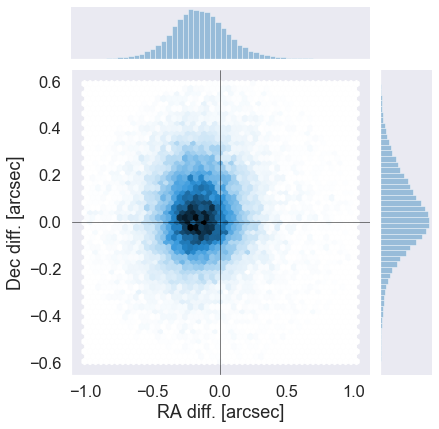

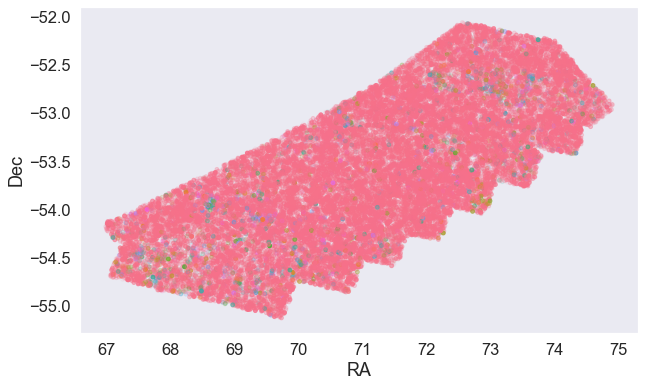

In [10]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [11]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.1570234825493344 arcsec
Dec correction: -0.025492089565659626 arcsec


In [12]:
catalogue[RA_COL] = catalogue[RA_COL] + delta_ra.to(u.deg)
catalogue[DEC_COL] = catalogue[DEC_COL] + delta_dec.to(u.deg)

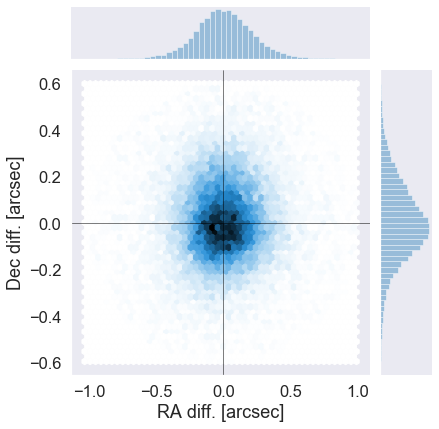

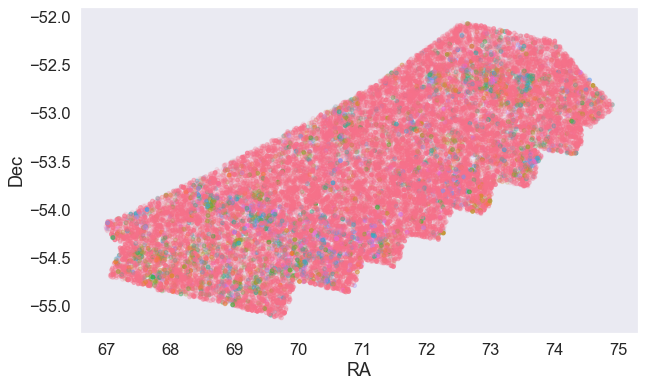

In [13]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [14]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [15]:
GAIA_FLAG_NAME = "servs_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

28972 sources flagged.


## V - Saving to disk

In [16]:
catalogue.write("{}/SIMES_8.fits".format(OUT_DIR), overwrite=True)